In [8]:
import analysis

In [9]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import numpy as np
import ipywidgets as widgets
import scipy as sp
from scipy.fft import fft, fftfreq
import seaborn as sns
import os

In [10]:
semiimplicit_dir = Path("/home/marksta/scratch/semiimplicit")
out = Path('fft')
os.makedirs(out, exist_ok=True)

In [11]:
def plot_Ey(series, case, time):
    # Get dimensions (x,y) in mm
    x_mm = series.data[0].grid1D(axis=0).v * 1000
    y_mm = series.data[0].grid1D(axis=1).v * 1000
    left, right = min(x_mm), max(x_mm)
    bottom, top = min(y_mm), max(y_mm)
    extent = (left, right, top, bottom)
    dx = x_mm[-1] - x_mm[0]
    dy = y_mm[-1] - x_mm[0]

    # load Ey at given time
    index = next(n for n, t in enumerate(series.time) if t > time)
    Ey = series.load("Ez", dimension = 2, inds = [index])[0]

    # compute fig dimensions
    aspect_2D = dx / dy * 1.1
    figwidth = 13
    figheight = 5
    
    im_width = 0.8 * figwidth
    cb_width = 0.03 * figwidth
    ln_width = 0.17 * figwidth
    
    widths = [cb_width, im_width, ln_width]
    w_total = sum(widths)
    width_ratios = [w / w_total for w in widths]

    # create layout
    fig = plt.figure(figsize = (figwidth, figheight))
    gs = fig.add_gridspec(1, 3, width_ratios = width_ratios)
    ax_cb = fig.add_subplot(gs[0])
    ax_im = fig.add_subplot(gs[1])
    
    Emin = -40
    Emax = 40
    im = ax_im.imshow(Ey / 1000, extent = extent, origin = 'lower', cmap = "RdBu_r", vmin = Emin, vmax = Emax, aspect = 'auto')
    ax_im.set_xlabel("x [mm]")
    ax_im.set_ylabel("y [mm]")
    
    cb = plt.colorbar(im, cax = ax_cb, label = "Electric field [kV/m]", location = "left")
    
    ax_ln = fig.add_subplot(gs[2])
    ax_ln.set_xlim(Emin, Emax)
    ax_ln.set_ylim(bottom, top)
    ax_ln.set_xlabel("$E_y$ [kV/m]")
    
    ax_ln.set_yticklabels([])
    
    # slices at specific axial locations
    positions = [3, 15]
    colors = ["xkcd:cerulean", "xkcd:scarlet"]
    for (x_position, color) in zip(positions, colors):
        x_index = next(n for n, x in enumerate(x_mm) if x > x_position)
        x_position = x_mm[x_index]
        Ey_slice = Ey[:, x_index]
    
        ax_im.axvline([x_position], color = color, linestyle = '--')
        ax_ln.plot(Ey_slice/1000, y_mm, color = color)
    
    plt.tight_layout()
    
    fig.savefig(out/f"Ey_{case}.png", dpi=200)
    plt.show()

In [12]:
#frequency_spectra = [analysis.frequency_spectrum(serie, 1.6e-6) for serie in series]

In [13]:
#wavenumber_spectra = [analysis.wavenumber_spectrum(serie, 1.6e-6) for serie in series]

In [14]:
def skewed_colormap(cmap, midpoint = 0.5, N = 256):
    def transform_t(t, midpoint):
        t1 = np.zeros(t.size)
        l = t <= midpoint
        r = t > midpoint
        t1[l] = 0.5 * (t[l]/midpoint)
        t1[r] = 0.5 * (1 + (t[r] - midpoint)/(1 - midpoint))
        return t1
        
    t0 = np.linspace(0, 1, N)
    t1 = transform_t(t0, midpoint)
    colors = cmap(t1)
    return mpl.colors.ListedColormap(colors, name=cmap.name + f"_midpt{midpoint}")

In [15]:
def plot_fft(series, case, start_time):
    x_mm = series.data[0].grid1D(axis=0).v * 1000
    y_mm = series.data[0].grid1D(axis=1).v * 1000

    grid = np.linspace(x_mm[0], x_mm[-1], 11)[1:-1]
    dy = (y_mm[1] - y_mm[0])/1000 
    Ly = (y_mm[-1] - y_mm[0])/1000
    
    cmap = plt.colormaps["coolwarm"]
    
    x_mid = 5
    x_diff_l = x_mid - x_mm[0]
    x_diff_r = grid[-1] - x_mid
    x_diff_t = x_diff_l + x_diff_r
    midpoint = x_mid / x_diff_t
    my_cmap = skewed_colormap(cmap, midpoint)

    fig, ax = plt.subplots(figsize=(8,6))
    
    s = analysis.wavenumber_spectrum(series, start_time)
    
    for (i, x) in enumerate(grid):
        
        wavelength = 1 / (k * Ly)
    
        color_t = (x - grid[0]) / (grid[-1] - grid[0])
    
        ax.loglog(wavelength, Ey_fft, label = f"x = {x} mm", color = my_cmap(color_t))
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=mpl.colors.Normalize(vmin = grid[0], vmax = grid[-1]))
    plt.colorbar(sm, ax=ax, label = "Axial location [mm]")
    #ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    ax.set_xlim(0.01, 1)
    ax.set_xlabel("$\lambda / L_y$")
    ax.set_ylabel("Electric field amplitude [V/m]")
    ax.set_ylim(100, 2e4)
    ax.axvline([2*np.pi*dy/Ly], color = 'black')
    ax.grid()
    fig.savefig(out/f"wavenumber_{case}.png", dpi=200)
    plt.show()

In [30]:
start_time = 1.2e-5
cases = ['baseline', 'grid-2-timestep-2-si-8', 'grid-4-timestep-4-si-8', 'grid-8-timestep-8-si-8']
data_dirs = [semiimplicit_dir / case / 'diags' for case in cases]
series = [analysis.DataSeries(data_dir, start_time = 0.9 * start_time) for data_dir in data_dirs]

Data Ez loaded.


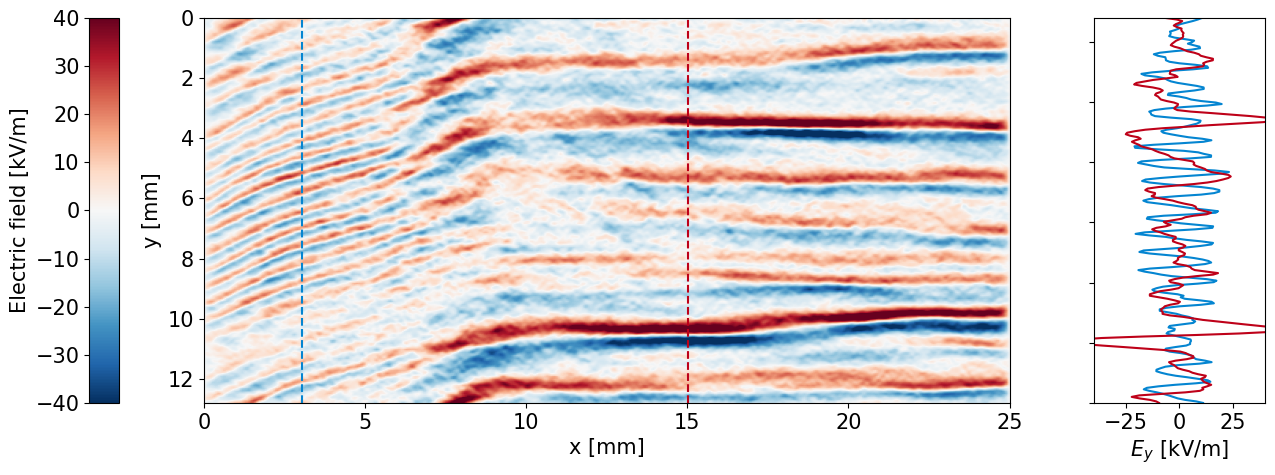

Data Ez loaded.


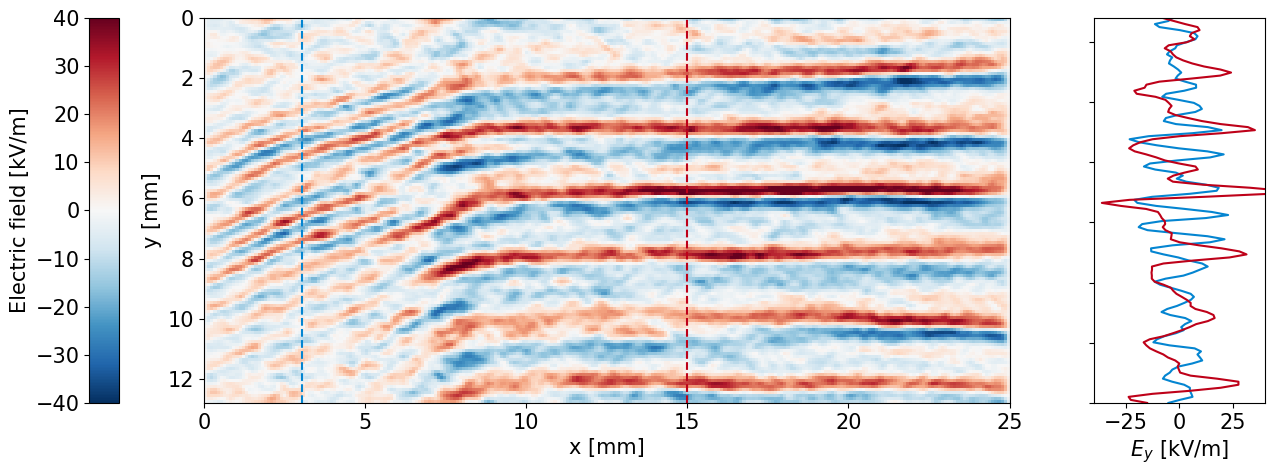

Data Ez loaded.


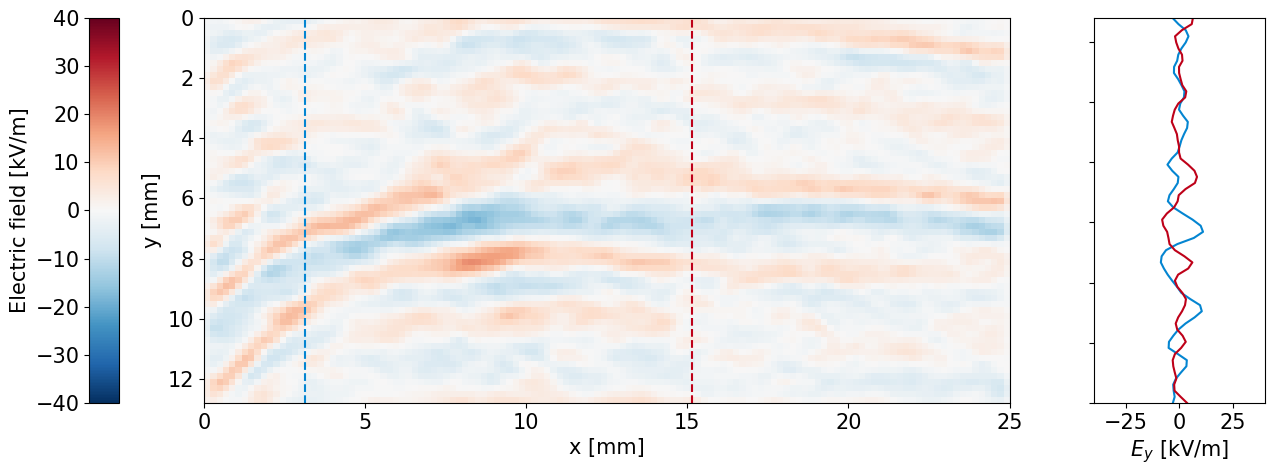

Data Ez loaded.


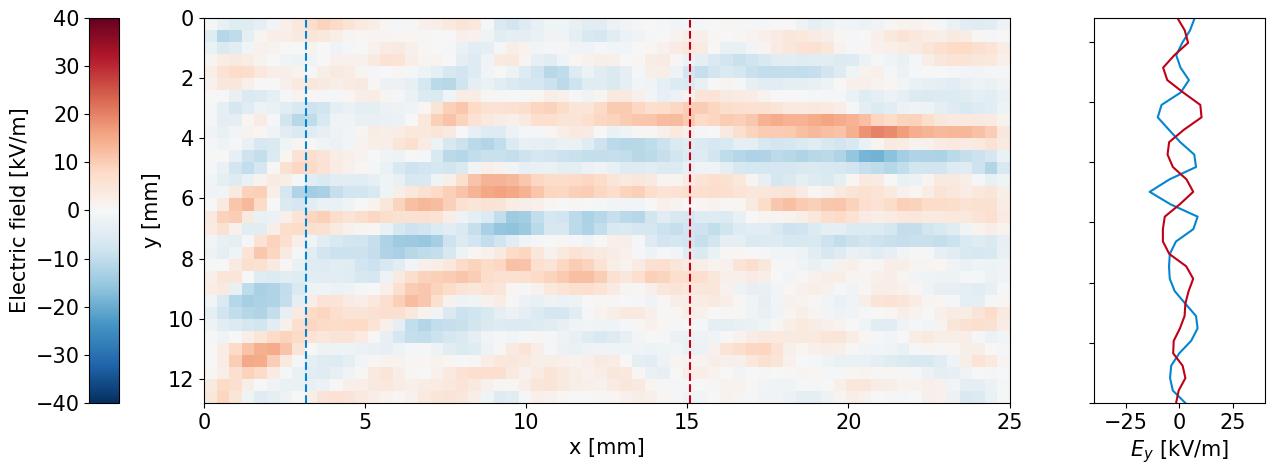

In [31]:
for (case, serie) in zip(cases, series):
     plot_Ey(serie, case, start_time)

In [32]:
def b_field(x):
    B = np.zeros_like(x)

    Lx = 0.025

    B_max = 1e-2           # Peak magnetic field strength (T)
    B0 = 0.6 * B_max       # Magnetic field at anode
    B_min = 0.1 * B_max    # Magnetic field at Lx
    sigma_B_1 = 0.25 * Lx  # Width of magnetic field profile
    sigma_B_2 = sigma_B_1
    x_Bmax = 0.3 * Lx  # Location of peak magnetic field strength
    
    exp_factor_1 = np.exp(-0.5 * (x_Bmax / sigma_B_1) ** 2)
    exp_factor_2 = np.exp(-0.5 * ((Lx - x_Bmax) / sigma_B_2) ** 2)
    a1 = (B_max - B0) / (1 - exp_factor_1)
    a2 = (B_max - B_min) / (1 - exp_factor_2)
    b1 = (B0 - B_max * exp_factor_1) / (1 - exp_factor_1)
    b2 = (B_min - B_max * exp_factor_2) / (1 - exp_factor_2)

    x_left = x[x<x_Bmax]
    x_right = x[x >= x_Bmax]
    
    B[x < x_Bmax] = a1 * np.exp(-0.5 * (x_left - x_Bmax)**2 / sigma_B_1**2) + b1
    B[x >= x_Bmax] = a2 * np.exp(-0.5 * (x_right - x_Bmax)**2 / sigma_B_2**2) + b2

    return B